In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 비트코인 시세 예측하기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file_path = '/content/drive/MyDrive/이것이데이터분석이다/ch3/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

### [데이터셋의 기본정보]

In [4]:
print(bitcoin_df.shape)
print(bitcoin_df.info())

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [5]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


### [시계열 데이터 살펴보기]

In [6]:
# to_datetime으로 day 피처를 시계열 피처로 변환하기
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 피처를 데이터프레임의 index로 설정하기
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000


In [7]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


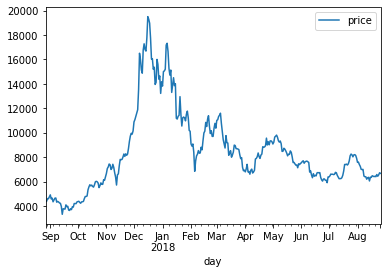

In [8]:
bitcoin_df.plot()
plt.show()

## 파이썬 라이브러리를 활용한 시세 예측
### [ARIMA 모델 활용하기]

In [9]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델 학습하기
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2780.074
Method:                       css-mle   S.D. of innovations            501.536
Date:                Thu, 30 Jun 2022   AIC                           5572.148
Time:                        15:08:14   BIC                           5595.531
Sample:                             1   HQIC                          5581.442
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4013     26.944      0.238      0.812     -46.408      59.210
ar.L1.D.y      0.4496      0.029     15.512      0.000       0.393       0.506
ar.L2.D.y     -0.9622      0.023    -42.314      0.0

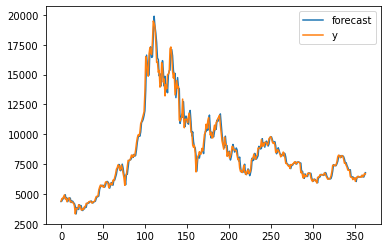

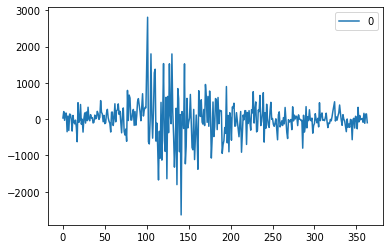

In [10]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화
residuals.plot()

In [11]:
# 학습 데이터셋으로부터 5일 뒤를 예측합니다.
forecast_data = model_fit.forecast(steps=5)

# 테스트 텟 불러오기
test_file_path = '/content/drive/MyDrive/이것이데이터분석이다/ch3/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds','y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

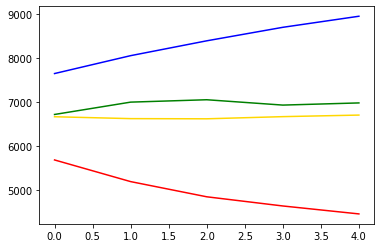

In [12]:
plt.plot(pred_y, color='gold')
plt.plot(pred_y_lower, color='red')
plt.plot(pred_y_upper, color='blue')
plt.plot(test_y, color='green')

In [13]:
for i in forecast_data:
    print(i,'\n')

[6667.38574684 6624.5383579  6620.62176949 6669.77318127 6705.32440227] 

[ 501.53573902  731.11598285  905.44074808 1037.14451798 1147.49917115] 

[[5684.3937614  7650.37773227]
 [5191.57736299 8057.49935281]
 [4845.99051311 8395.25302587]
 [4637.00727927 8702.53908326]
 [4456.26735453 8954.38145001]] 



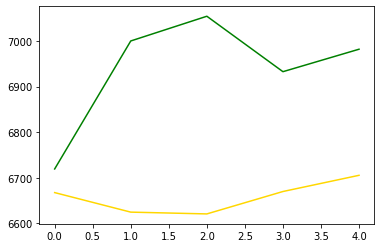

In [14]:
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

308.9918479649999


### [Facebook Prophet 활용하기]

In [16]:
from fbprophet import Prophet

In [17]:
bitcoin_df = pd.read_csv(file_path, names=['ds','y'])
prophet = Prophet(seasonality_mode = 'multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

모델로부터 예측할 기간을 정의하고, 결과를 도출

In [18]:
# 5일을 내다보며 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

forecast_data.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,764.084863,6215.994797,7559.112672,764.084863,764.084863,9.199609,9.199609,9.199609,8.037644,...,-0.006656,-0.006656,-0.006656,-1.155308,-1.155308,-1.155308,0.0,0.0,0.0,6905.527347
366,2018-08-28,768.336548,6331.621214,7711.506541,768.336548,768.336548,9.199609,9.199609,9.199609,8.107785,...,0.017172,0.017172,0.017172,-1.108996,-1.108996,-1.108996,0.0,0.0,0.0,6997.844342
367,2018-08-29,772.588234,6333.476159,7718.504835,772.588234,772.588234,9.199609,9.199609,9.199609,8.077803,...,-0.044443,-0.044443,-0.044443,-1.077362,-1.077362,-1.077362,0.0,0.0,0.0,7013.403913
368,2018-08-30,776.839919,6373.872924,7871.867672,776.839919,783.452746,9.199609,9.199609,9.199609,8.123141,...,-0.013299,-0.013299,-0.013299,-1.063168,-1.063168,-1.063168,0.0,0.0,0.0,7087.220378
369,2018-08-31,781.091605,6397.089156,7964.037839,777.167845,800.745155,9.199609,9.199609,9.199609,8.166408,...,0.035406,0.035406,0.035406,-1.068606,-1.068606,-1.068606,0.0,0.0,0.0,7159.804669


In [19]:
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-08-27,492.880489,3753.408701,5060.090050,492.880489,492.880489,9.199609,9.199609,9.199609,8.019670,...,-0.037415,-0.037415,-0.037415,-1.142524,-1.142524,-1.142524,0.0,0.0,0.0,4445.619442
1,2017-08-28,496.084388,3846.738985,5213.957924,496.084388,496.084388,9.199609,9.199609,9.199609,8.093358,...,-0.006656,-0.006656,-0.006656,-1.099594,-1.099594,-1.099594,0.0,0.0,0.0,4511.072950
2,2017-08-29,499.288286,3942.891434,5215.729457,499.288286,499.288286,9.199609,9.199609,9.199609,8.144698,...,0.017172,0.017172,0.017172,-1.072083,-1.072083,-1.072083,0.0,0.0,0.0,4565.840584
3,2017-08-30,502.492185,3875.798716,5209.916796,502.492185,502.492185,9.199609,9.199609,9.199609,8.092551,...,-0.044443,-0.044443,-0.044443,-1.062614,-1.062614,-1.062614,0.0,0.0,0.0,4568.935834
4,2017-08-31,505.696084,3963.904018,5291.396426,505.696084,505.696084,9.199609,9.199609,9.199609,8.113077,...,-0.013299,-0.013299,-0.013299,-1.073232,-1.073232,-1.073232,0.0,0.0,0.0,4608.447417


In [20]:
print(forecast_data.shape)
print(forecast_data.info())

(370, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          370 non-null    datetime64[ns]
 1   trend                       370 non-null    float64       
 2   yhat_lower                  370 non-null    float64       
 3   yhat_upper                  370 non-null    float64       
 4   trend_lower                 370 non-null    float64       
 5   trend_upper                 370 non-null    float64       
 6   daily                       370 non-null    float64       
 7   daily_lower                 370 non-null    float64       
 8   daily_upper                 370 non-null    float64       
 9   multiplicative_terms        370 non-null    float64       
 10  multiplicative_terms_lower  370 non-null    float64       
 11  multiplicative_terms_upper  370 non-null    floa

In [21]:
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6905.527347,6215.994797,7559.112672
366,2018-08-28,6997.844342,6331.621214,7711.506541
367,2018-08-29,7013.403913,6333.476159,7718.504835
368,2018-08-30,7087.220378,6373.872924,7871.867672
369,2018-08-31,7159.804669,6397.089156,7964.037839


### [결과의 시각화]
*   전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화하기

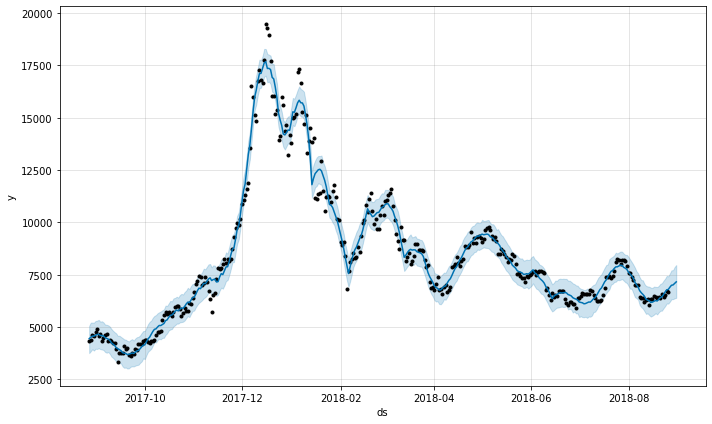

In [22]:
fig1 = prophet.plot(forecast_data)

*   seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화

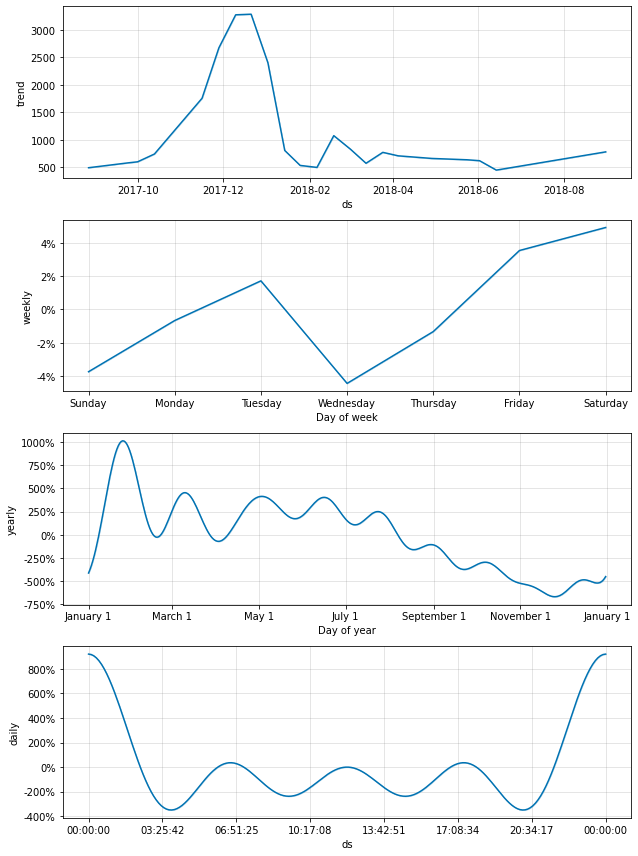

In [23]:
fig2 = prophet.plot_components(forecast_data)

모델의 성능
*   실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산한다.

In [24]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터

In [25]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

519.3202733511736
0.9740759995762933


---
실제 데이터와의 비교
*   예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교


In [26]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds','y'])

pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

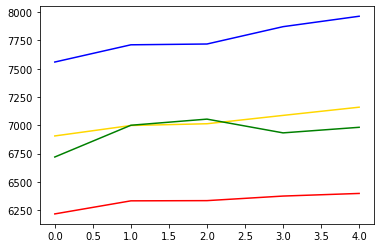

In [27]:
plt.plot(pred_y, color='gold')
plt.plot(pred_y_lower, color='red')
plt.plot(pred_y_upper, color='blue')
plt.plot(test_y, color='green')

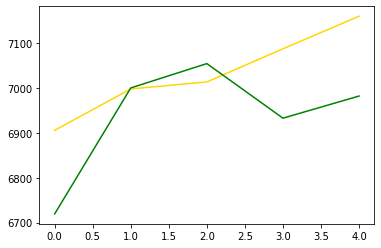

In [28]:
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')

In [29]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

135.56578077732078


## 더 나은 결과를 위한 방법들
### [상한가 및 하한가 선정]
*   주가데이터의 경우 의미가 없지만, 일반적인 시계열 데이터의 경우 상한값 혹은 하한값을 잘 설정해주는 것이 도움이 되기도 한다.

In [30]:
bitcoin_df = pd.read_csv(file_path, names=['ds','y'])

# 상한가 설정
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정합니다.
prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

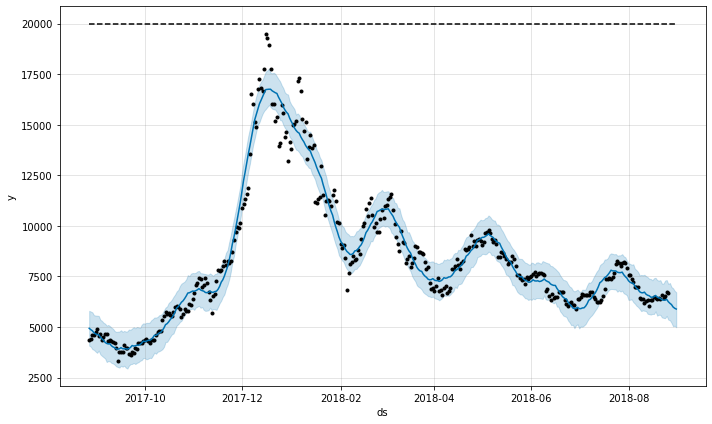

In [31]:
# 5일을 내다보며 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

실제 데이터와 비교
*   비트코인 데이터의 경우, 상한선을 둠으로써 오히려 예측력이 다소 떨어지는 결과를 보인다.

In [32]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

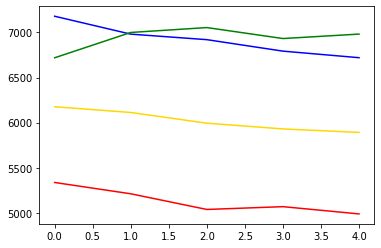

In [33]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

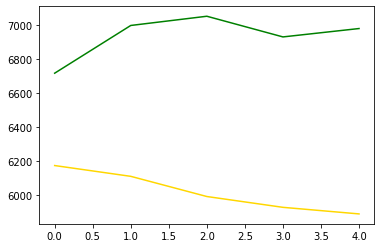

In [34]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [35]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

938.2091929791845


### [이상치 제거하기]
*   가격이18.000을 넘어가는 값을 이상치로 판단하여 제거

In [36]:
bitcoin_df = pd.read_csv(file_path, names=['ds','y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

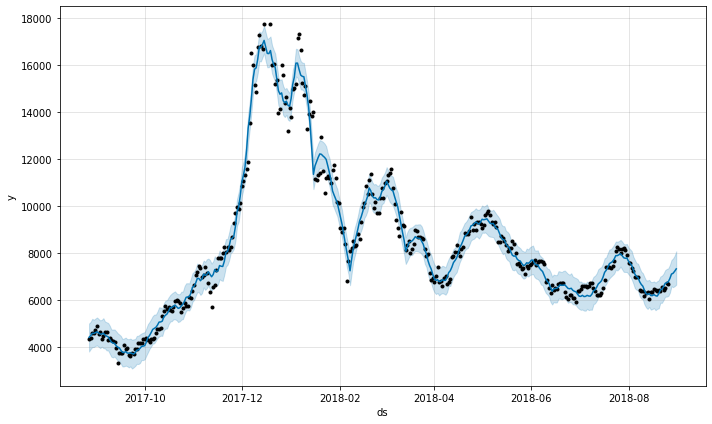

In [37]:
# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data)

실제 데이터와의 비교
*   비트코인 데이터의 경우, 이상치를 제거함으로써 오히려 예측력이 다소 떨어지는 결과를 보였다
*   모델의 정확도 스코어 측면에서는 떨어졌지만, 트렌드 예측의 측면에서는 다소 나은 모습을 보여줄 수 있다.

In [38]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

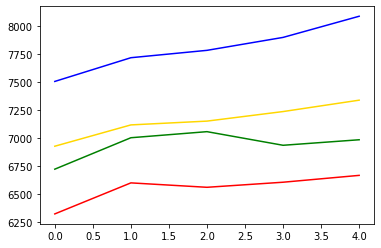

In [39]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

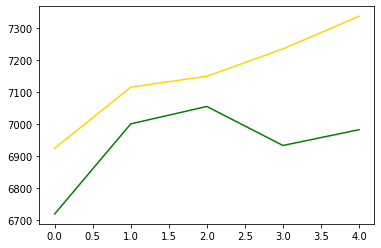

In [40]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [41]:
# 테스트 데이터의 RMSE를 출력합니다.
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

236.5613031987836


## [ARIMA 모델의 하이퍼 파라미터 선정하기]
적절한 파라미터 선정하기
*   ARIMA 모델은 p,d,q 세 가지 파라미터를 적절하게 선정하는 것이 가장 중요
*   ACF, PACF 그래프를 통해 대략적인 파라미터를 선정한다

In [42]:
bitcoin_df = pd.read_csv(file_path, names=['day','price'])
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

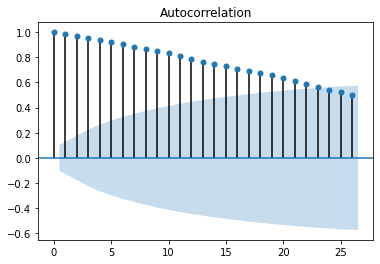

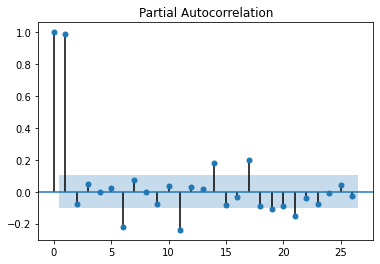

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_df.price.values)
plot_pacf(bitcoin_df.price.values)
plt.show()

ARIMA 모델 학습
*   그래프를 토대로 1차 학습

In [44]:
model = ARIMA(bitcoin_df.price.values, order=(15,2,0))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  363
Model:                ARIMA(15, 2, 0)   Log Likelihood               -2766.312
Method:                       css-mle   S.D. of innovations            491.703
Date:                Thu, 30 Jun 2022   AIC                           5566.625
Time:                        15:09:07   BIC                           5632.830
Sample:                             2   HQIC                          5592.941
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0056      4.347     -0.001      0.999      -8.525       8.514
ar.L1.D2.y     -0.8160      0.052    -15.652      0.000      -0.918      -0.714
ar.L2.D2.y     -0.7860      0.068    -11.633    

*   1차 결과를 토대로 2차 학습

In [45]:
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2780.074
Method:                       css-mle   S.D. of innovations            501.536
Date:                Thu, 30 Jun 2022   AIC                           5572.148
Time:                        15:09:21   BIC                           5595.531
Sample:                             1   HQIC                          5581.442
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4013     26.944      0.238      0.812     -46.408      59.210
ar.L1.D.y      0.4496      0.029     15.512      0.000       0.393       0.506
ar.L2.D.y     -0.9622      0.023    -42.314      0.0

### [Prophet 모델로 향후 5일간의 비트코인 시세 예측하기]

In [46]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names = ['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [47]:
# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [48]:
# 테스트 데이터를 불러옵니다.
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 마지막 5일의 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

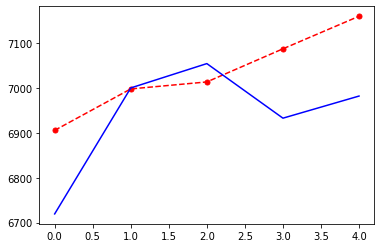

In [49]:
plt.plot(pred_y, color="red", ls="--", marker="o", ms=5) # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="blue") # 실제 가격 그래프입니다.